# Model-based machine learning - Chapter 2 - Assessing People’s Skills

This notebook is based on the [Model-based machine learning - Chapter 2 - Assessing People’s Skills](http://mbmlbook.com/LearningSkills.html) and this [forum thread](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464) using [Pyro](http://pyro.ai) and [PyTorch](https://pytorch.org).<br>

## Imports

In [158]:
import torch
import pyro
import pyro.infer
import pyro.optim

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pdb

In [5]:
pyro.__version__

'0.3.0'

In [6]:
assert pyro.__version__.startswith('0.3.0')

In [7]:
pyro.enable_validation(True)

In [8]:
pyro.set_rng_seed(0)

## Load data

### Raw responses data

"Raw data collected from volunteers completing a real assessment test. This data consists of the self-assessed skills (S1-S7) and the answers to each question (Q1-Q48). The first row of data gives the correct answers to each question. Each subsequent row gives the data for one of the participants."

In [11]:
raw_responses = pd.read_csv('http://mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-RawResponsesAsDictionary.csv')

In [12]:
raw_responses.head()

,#,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
0,ANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,...,2,1,5,4,2,5,2,2,2,1
1,P1,True,True,True,True,False,True,True,2,4,...,2,1,5,4,2,5,2,2,2,1
2,P2,True,True,True,True,False,False,True,1,4,...,5,1,1,4,3,3,4,4,3,1
3,P3,False,False,False,True,False,True,False,3,4,...,2,1,5,4,2,5,5,3,3,1
4,P4,True,True,False,True,False,False,False,2,4,...,2,5,5,4,2,5,4,2,3,1


### Skills for questions data

In [13]:
skills_questions_mask = pd.read_csv('http://mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv', header=None)

In [14]:
#skills_questions_mask.T.head()

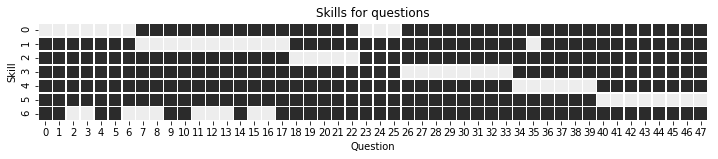

In [134]:
# Adapted from http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/
f, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(skills_questions_mask.T, linewidths=0.25, ax=ax, square=True, cbar=False, cmap=sns.color_palette('Greys_r'))
ax.set(title='Skills for questions', xlabel='Question', ylabel='Skill')
plt.show()

"Each row corresponds to a skill and each column to a question. White squares show which skills are needed for each question" ([see Figure 2.14](http://mbmlbook.com/LearningSkills_Moving_to_real_data.html))

### Responses data

In [16]:
responses = pd.read_csv('http://mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-IsCorrect.csv', header=None)

In [17]:
#responses.T.head()

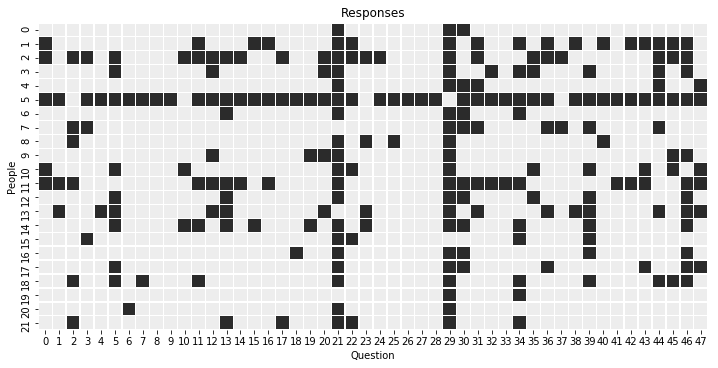

In [135]:
f, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(responses.T, linewidths=0.25, ax=ax, square=True, cbar=False, cmap=sns.color_palette('Greys_r'))
ax.set(title='Responses', xlabel='Question', ylabel='People')
plt.show()

"Each row corresponds to a person and again each column corresponds to a question. Here, white squares show which questions each person got correct." ([see Figure 2.14](http://mbmlbook.com/LearningSkills_Moving_to_real_data.html))

## Model setup

In [22]:
skills_needed = torch.tensor(skills_questions_mask.T.values.astype(np.float32))

In [23]:
people_n = 22
skills_n = 7
questions_n = 48

guess_probs = 0.2
mistake_probs = 0.1

## Basic model

In [154]:
def basic_model():
    
    # declare dimensions as conditionally independent
    with pyro.plate('people', people_n):
        with pyro.plate('skills', skills_n):
            skills = pyro.sample('skills', pyro.distributions.Bernoulli(0.5))
    
    # setup empty arrays
    has_skills = torch.zeros((people_n, questions_n))
    is_correct_probs = torch.zeros((people_n, questions_n))
    is_correct = torch.zeros((people_n, questions_n))
    
    # declare dimensions as conditionally independent
    for p in pyro.plate('people', people_n):
        for q in pyro.plate('questions', questions_n):
            
            # skills_needed AND skills
            has_skills[p,q] = torch.tensor(torch.allclose(skills_needed[:,q], skills[:,p])).float()
            
            # probabilites
            is_correct_probs[p,q] = has_skills[p,q] * (1 - mistake_probs) + (1 - has_skills[p,q]) * guess_probs
            
            # sample is correct
            is_correct[p,q] = pyro.sample('is_correct_{}'.format(q), pyro.distributions.Bernoulli(is_correct_probs[p,q]))
    
    return skills, has_skills, is_correct

In [155]:
skills, has_skills, is_correct = basic_model()

In [115]:
skills.shape, has_skills.shape, is_correct.shape

(torch.Size([7, 22]), torch.Size([22, 48]), torch.Size([22, 48]))

In [137]:
is_correct_avg_pp = torch.zeros(22,48)
n = 100

for i in range(n):
    _, _, is_correct = basic_model()
    is_correct_avg_pp += is_correct
    
is_correct_avg_pp /= n

In [138]:
is_correct_avg_pp

tensor([[0.2700, 0.2100, 0.1700,  ..., 0.2200, 0.2000, 0.2200],
        [0.3000, 0.2100, 0.1700,  ..., 0.1900, 0.1900, 0.3300],
        [0.1600, 0.1900, 0.1400,  ..., 0.3100, 0.2200, 0.2300],
        ...,
        [0.1600, 0.2100, 0.2400,  ..., 0.2400, 0.2100, 0.1600],
        [0.2000, 0.1600, 0.1500,  ..., 0.2600, 0.2500, 0.2000],
        [0.1900, 0.2400, 0.2200,  ..., 0.1100, 0.2000, 0.1900]])

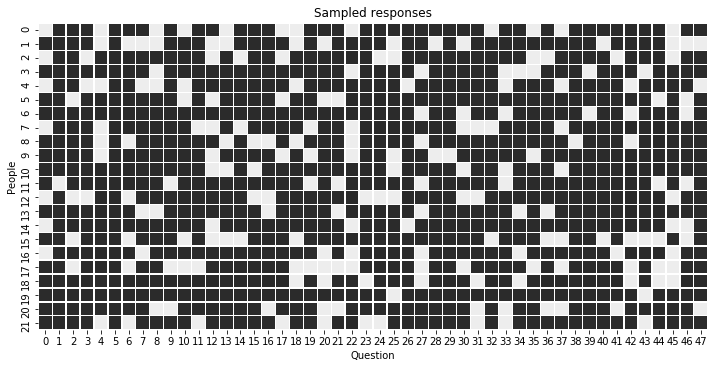

In [140]:
f, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(is_correct.detach().numpy(), linewidths=0.25, ax=ax, square=True, cbar=False, cmap=sns.color_palette('Greys_r'))
ax.set(title='Sampled responses', xlabel='Question', ylabel='People')
plt.show()

## Extended model

In [179]:
def ext_model():
    
    alpha0 = torch.ones(questions_n) * 2.5
    beta0 = torch.ones(questions_n) * 7.5
    
    guess_probs = pyro.sample('guess_probs', pyro.distributions.Beta(alpha0, beta0).independent(1))
    
    # setup empty arrays
    has_skills = torch.zeros((people_n, questions_n))
    is_correct_probs = torch.zeros((people_n, questions_n))
    is_correct = torch.zeros((people_n, questions_n))
    
    # declare dimensions as conditionally independent
    with pyro.plate('people', people_n):
        with pyro.plate('skills', skills_n):
            skills = pyro.sample('skill', pyro.distributions.Bernoulli(0.5))
    
    # declare dimensions as conditionally independent
    for p in pyro.plate('people', people_n):
        for q in pyro.plate('questions', questions_n):
            
            # skills_needed AND skills
            has_skills[p,q] = torch.tensor(torch.allclose(skills_needed[:,q], skills[:,p])).float()
            
            # probabilites
            is_correct_probs[p,q] = has_skills[p,q] * (1 - mistake_probs) + (1 - has_skills[p,q]) * guess_probs[q]
            
            # sample is correct
            is_correct[p,q] = pyro.sample('is_correct_{}'.format(q), pyro.distributions.Bernoulli(is_correct_probs[p,q]))
    
    return skills, has_skills, is_correct

In [180]:
skills, has_skills, is_correct = ext_model()

NameError: name 'p' is not defined

In [173]:
skills.shape, has_skills.shape, is_correct.shape

(torch.Size([7, 22]), torch.Size([22, 48]), torch.Size([22, 48]))

In [175]:
def ext_guide():
    alpha0 = pyro.param('alpha0', torch.ones(questions_n) * 4)
    beta0 = pyro.param('beta0', torch.ones(questions_n) * 4)
    
    guess_probs = pyro.sample('guess_probs', pyro.distributions.Beta(alpha0, beta0).independent(1))

In [176]:
# From https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/3

def reset_torch_seed(seed=99):
    torch.manual_seed(seed);

def SVI(vals, model, guide, lr = 0.0001, steps=1000):
    reset_torch_seed()
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model = model,
                        guide = guide,
                        optim = pyro.optim.SGD({"lr":lr}),
                        #optim = pyro.optim.Adam({"lr":lr}), 
                        loss = pyro.infer.Trace_ELBO())
    
    losses = []
    for t in range(steps):
        losses.append(svi.step(*vals)) # vals will be passed to model and guide
        
    plt.plot(losses)
    plt.title("ELBO")
    plt.xlabel("step")
    plt.ylabel("loss")

In [177]:
SVI([], pyro.condition(ext_model, data=data), ext_guide, lr = 0.001, steps=1000)

NameError: name 'data' is not defined

In [178]:
SVI([], ext_model, ext_guide, lr = 0.001, steps=1000)

RuntimeError: Multiple sample sites named 'people'
   Trace Shapes:          
    Param Sites:          
   Sample Sites:          
guess_probs dist      | 48
           value      | 48
     people dist      |   
           value   22 |   
     skills dist      |   
           value    7 |   
      skill dist 7 22 |   
           value 7 22 |   

In [ ]:
data = {'isCorrect'+str(index):torch.tensor(row.values.astype(float)).float() for index, row in responses.iterrows() }